<a href="https://colab.research.google.com/github/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/supplementary/what_is_to_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Modules**

In [ ]:
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import math
from numpy import linalg
import sympy

from sympy import symbols
from sympy import *
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
init_vprinting(pretty_print=True)

import plotly.graph_objects as go

In [ ]:
# Install the simulation helpers
!pip install --quiet "git+https://github.com/mugalan/classical-mechanics-from-a-geometric-point-of-view.git#egg=rigid-body-sim"
import sims
mr = sims.RigidBodySim()

#How can we describe the behavior of this system

https://youtu.be/zq05N8m_9SA?si=BZoW8XY6asHbaNE7

https://youtu.be/O0tPGOYFIfw?si=_R2WrPAT8kHpAysK

## Abstraction

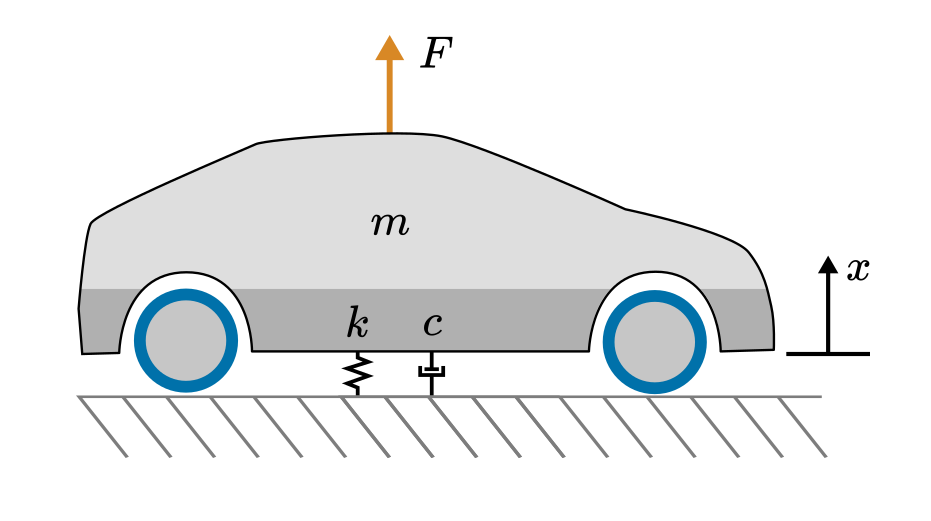

## Lets try this?

### The approximate model of the system

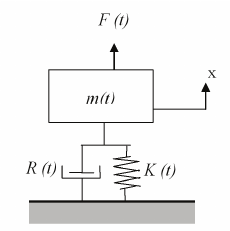

Newtons equations for this approximately modelled system gives us that
\begin{align*}
m\ddot{x}+c\dot{x}+kx=F
\end{align*}

This is a second order linear differential equation.

### What does this differential equation tells us?

The above equations can be reduced to the form

\begin{align*}
\ddot{x}+2\zeta \omega_n\dot{x}+\omega_n^2x=\frac{1}{m}F
\end{align*}
where we have set $\omega_n^2=k/m$ and $2\zeta\omega_n=c/m$.

#### Lets try to find the solutions of this differential equation

The above system can also be written down as a first order matrix ODE
\begin{align*}
\dot{Y}=AY+BF
\end{align*}
where
\begin{align*}
A=\left[\begin{matrix}0 & 1\\- \omega_{n}^{2} & - 2 \omega_{n} \zeta\end{matrix}\right],
\end{align*}
\begin{align*}
B=\left[\begin{matrix}0 \\\frac{1}{m}\end{matrix}\right]
\end{align*}
and
\begin{align*}
Y=\left[\begin{matrix}x \\ \dot{x}\end{matrix}\right]
\end{align*}

####Numerical Solution

In [ ]:
m=1; k=10; c=float(m*2*0.1*sqrt(k/m));
A=np.array([[0,1],[-k/m,-c/m]]);
[t,sol,fig]=mr.simulate_dy_system(mr.LinearSystemModel, 10,0.01, [1,0], A, 'Spring Mass Damper System', 'Time / t', 'x')

#### Analytical Solution

Taking the Laplase transform of the above linear ODE The transfer function representation of this system is
\begin{align*}
X(s)=G(s)U(s)
\end{align*}
where $U(s)=F(s)/m$ and
\begin{align*}
G(s)=\frac{1}{s^{2} + 2 \zeta\omega_{n} s  + \omega_{n}^{2}}
\end{align*}

The roots of the denomunator pynomial
\begin{align*}
f(s)=s^2+2\zeta\omega_n s+\omega_n^2
\end{align*}
is given by

In [ ]:
s, omega_n , zeta = symbols('s omega_n zeta', real=True)
fs = s**2 + (2*zeta*omega_n*s) + (omega_n**2)
solve(fs, s)

#### The parameter dependence of the roots

In [ ]:
import matplotlib.pyplot as plt

# Define parameters
omega_n = 1  # Natural frequency
zeta = np.linspace(0, 2, 500)  # Damping ratio range

# Compute roots
s1 = -omega_n * zeta + omega_n * np.sqrt(zeta**2 - 1 + 0j)  # Root 1
s2 = -omega_n * zeta - omega_n * np.sqrt(zeta**2 - 1 + 0j)  # Root 2

# Separate real and imaginary parts
s1_real, s1_imag = s1.real, s1.imag
s2_real, s2_imag = s2.real, s2.imag

# Plot the roots
plt.figure(figsize=(10, 6))

plt.plot(s1_real, s1_imag, label="Root 1 (Real vs Imag)", color="blue")
plt.plot(s2_real, s2_imag, label="Root 2 (Real vs Imag)", color="red")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.axvline(0, color="black", linestyle="--", linewidth=0.8)

plt.title("Roots of the Polynomial $\\omega_{n}^2 + 2 \\omega_{n} s \\zeta + s^2$")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.legend()
plt.show()


#### The underdamped case: $0\leq\zeta <1$

For this case we see that the the partial fraction expansion of $G(s)$ takes the form
\begin{align*}
G(s)=\frac{1}{s^2+2\zeta\omega_n s+\omega_n^2}=\frac{i\alpha}{s+p}-\frac{i{\alpha}}{s+\bar{p}}
\end{align*}
where
\begin{align*}
\alpha = \frac{1}{2\omega_n\sqrt{1-\zeta^2}}.
\end{align*}

In [ ]:
s, omega_n , zeta = symbols('s omega_n zeta', real=True)
G = 1/(s**2 + (2*zeta*omega_n*s) + (omega_n**2))
G

In [ ]:
Gs = G.subs({zeta:0.9,omega_n:1.1})
Gs

In [ ]:
apart(Gs, full=True).doit()

####The analytical solution

The explicit analytical solution for $0<\zeta < 1$ is:

\begin{align*}
x(t) = e^{-\zeta \omega_n t} \left( x_0 \cos(\omega_d t) + \frac{v_0 + \zeta \omega_n x_0}{\omega_d} \sin(\omega_d t) \right),
\end{align*}

where:

\begin{align*}
\omega_d = \omega_n \sqrt{1 - \zeta^2}.
\end{align*}

#### How is this related to the solutions of the matrix ODE

\begin{align*}
\dot{Y}=AY+BF
\end{align*}
where
\begin{align*}
A=\left[\begin{matrix}0 & 1\\- \omega_{n}^{2} & - 2 \omega_{n} \zeta\end{matrix}\right],
\end{align*}
\begin{align*}
B=\left[\begin{matrix}0 \\\frac{1}{m}\end{matrix}\right]
\end{align*}
and
\begin{align*}
Y=\left[\begin{matrix}x \\ \dot{x}\end{matrix}\right]
\end{align*}

Find the eigenvalues and eigenvectors of

\begin{align*}
A=\left[\begin{matrix}0 & 1\\- \omega_{n}^{2} & - 2 \omega_{n} \zeta\end{matrix}\right]
\end{align*}

In [ ]:
omega_n , zeta = symbols('omega_n zeta', real=True)
E = Matrix([[0,1],[-omega_n**2, -2*zeta*omega_n]])
E

In [ ]:
E.eigenvals()

In [ ]:
E.eigenvects()

In [ ]:
init_printing()
E.eigenvects()

In [ ]:
init_printing(pretty_print=False)
E.eigenvects()

# Lets ask AI:

https://chatgpt.com/share/6921b0c7-4aa8-800b-881d-94d08f57b244

#**What are the challenges of Getting a Higher Education in an AI Driven World**

##WEC

https://chatgpt.com/share/67558833-bb70-800b-9312-11b9ee8c0b6d

## Top 5% of the age cohort

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Standard normal PDF
def pdf_standard_normal(z):
    return np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)

# 95th percentile z* (try SciPy if available; otherwise use the constant)
try:
    from scipy.stats import norm
    z_star = float(norm.ppf(0.95))      # ≈ 1.64485
    tail = float(norm.sf(z_star))       # should be ~0.05
except Exception:
    z_star = 1.6448536269514722
    tail = 0.05

# Grid and PDF
z = np.linspace(-4, 4, 1000)
pdf = pdf_standard_normal(z)

# Mask for the top 5% region
mask = z >= z_star

# Build figure
fig = go.Figure()

# Full PDF curve
fig.add_trace(
    go.Scatter(x=z, y=pdf, mode='lines', name='Standard normal PDF')
)

# Shaded top 5% area
fig.add_trace(
    go.Scatter(
        x=z[mask], y=pdf[mask],
        mode='lines',
        fill='tozeroy',
        name=f'Top 5% (z ≥ {z_star:.2f})'
    )
)

# Vertical line at z*
fig.add_vline(x=z_star, line_dash='dash', line_color='black')

# Annotation
fig.add_annotation(
    x=z_star,
    y=pdf_standard_normal(z_star),
    text=f"z* ≈ {z_star:.2f}\nArea ≈ {tail:.2%}",
    showarrow=True,
    yshift=20
)

fig.update_layout(
    title='Standard Normal (Z) — Top 5% Shaded',
    xaxis_title='z',
    yaxis_title='Density',
    template='plotly_white'
)

fig.show()

## 2025 CE1010

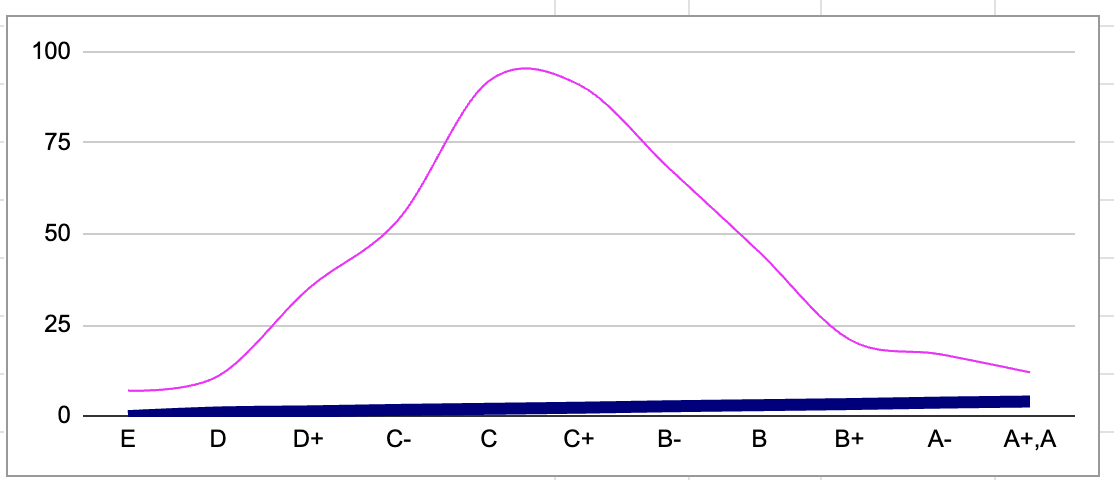

## What makes you a good learner?

### What DHSM Thinks

* Develop discipline
* Foster curiorsity
* Imagine, formulate, express, abstract
* Enjoy the process
* Dedicated iterative approach

### What AI-says

#### Mindset
- **Curiosity over coverage.** Chase questions, not pages; turn “I don’t get it” into a concrete question.
- **Error-friendly.** Treat mistakes as data—keep an *error log* (“what I thought vs. what was true”).
- **Calibration.** Predict your performance, then check reality to tighten self-assessment.

#### Methods (what actually grows skill)
- **Retrieval > re-reading.** Close the book and *pull* ideas from memory—quiz yourself, teach aloud, write from scratch.
- **Spacing & interleaving.** Short, repeated sessions over days; mix related topics to force discrimination.
- **Deliberate practice.** Target the weakest link with tasks just beyond comfort; define “better” beforehand.
- **Teach-back/Feynman.** Explain to a peer (or rubber duck). If you can’t, you don’t own it yet.
- **Dual coding & examples.** Pair words with diagrams/code/plots; study worked examples, then fade the support.

#### Systems (make learning automatic)
- **Define outcomes.** “I can solve X-type problems without notes in ≤15 min” beats “finish chapter.”
- **Question bank.** Collect your own problems; tag by concept and difficulty.
- **Lightweight notes.** Keep atomic notes (one idea each) with a **3–2–1** summary (3 key points, 2 connections, 1 question).
- **Tight loops.** Plan → Do → Reflect → Refine, weekly.

#### Environment & Energy
- **Protect focus.** One device, one window. Timer sprints (40–50 min on, 10 min off).
- **Sleep, movement, fuel.** You can’t out-tech bad biology; sleep and short walks amplify retention.
- **Context cues.** Same desk for sessions; reduce friction (templates, shortcuts, starter files).

#### Feedback & Community
- **Fast feedback.** Autograding, unit tests, answer keys, mentors—anything that collapses the time from attempt to insight.
- **Peer interaction.** Explain, debate, compare solutions; you’ll spot blind spots faster.

#### Transfer & Creativity
- **Vary contexts.** Apply the same idea across different domains/tools.
- **Build something.** Small, end-to-end projects force integration and beat massive unfinished ones.

#### Metrics That Matter
- **Recall rate** (on prior material after 48–72 h).
- **Learning velocity** (time to competent performance on a new subskill).
- **Error patterns** (what repeats, and why).

#### Common Pitfalls
Passive review, binge sessions, excessive highlighting, perfectionism, and tool-chasing instead of problem-chasing.

